In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier

from imblearn.over_sampling import SMOTE

The data frame will be created from the train data only and from there the split between training and testing data will be generated.
The test csv files won't be used at all for this exercise.

In [174]:
client_train = pd.read_csv(f'data/train/client_train.csv', low_memory=False)
invoice_train = pd.read_csv(f'data/train/invoice_train.csv', low_memory=False)

# Data exploration

#### client_train data frame

The dataset does not contain nulls or repeated values. However, a few data types and headers need adjusment

In [175]:
# data frame shape
print(f'the dataset contains {client_train.shape[0]} rows and {client_train.shape[1]} colums')

the dataset contains 135493 rows and 6 colums


In [176]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [177]:
# Check nulls
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [178]:
print(f'The dataset contains {client_train.duplicated().sum()} duplicates')

The dataset contains 0 duplicates


In [179]:
#Get a summary for all numerical columns
round(client_train.describe(),2)

,disrict,client_catg,region,target
count,135493.00,135493.00,135493.00,135493.00
mean,63.51,11.51,206.16,0.06
std,3.35,4.42,104.21,0.23
min,60.00,11.00,101.00,0.00
25%,62.00,11.00,103.00,0.00
50%,62.00,11.00,107.00,0.00
75%,69.00,11.00,307.00,0.00
max,69.00,51.00,399.00,1.00


In [180]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [181]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [182]:
#display all distinct elements
client_train['client_catg'].unique()

array([11, 12, 51])

In [183]:
#display all distinct elements
client_train['region'].unique()

array([101, 107, 301, 105, 303, 103, 309, 311, 304, 104, 312, 305, 306,
       308, 372, 307, 313, 310, 371, 302, 106, 379, 399, 206, 199])

## Data Types and Transforming Data

In [184]:
# type of first date entry
type(client_train['creation_date'][0])

str

In [185]:
# change "creation_date" dtype to datetime with format %d/%m/%Y
client_train['creation_date'] = pd.to_datetime(client_train['creation_date'], format='%d/%m/%Y')

In [186]:
# check "creation_date" dtype
type(client_train['creation_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [187]:
# change target variable to int
client_train['target'] = client_train['target'].astype(int)

In [188]:
# check tyoe for target
type(client_train['target'][0])

numpy.int64

#### invoice_train dataset

The data does not contain nulls. However, there are duplicates and data types issues. It is especially concerning the mix data types in colum counter_number.

In [189]:
# data frame shape
print(f'the dataset contains {invoice_train.shape[0]} rows and {invoice_train.shape[1]} colums')

the dataset contains 4476749 rows and 16 colums


In [190]:
#print top rows of dataset
invoice_train.head(5)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [191]:
invoice_train['counter_number'].sort_values().unique()

array([             0,              1,              2, ...,
       27391100365417, 27553463395500, 27981145458733], shape=(201893,))

In [192]:
# Check nulls
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [193]:
print(f'The dataset contains {invoice_train.duplicated().sum()} duplicates')

The dataset contains 11 duplicates


In [194]:
#Get a summary for all numerical columns
round(invoice_train.describe(),2)

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4476749.00,4.476749e+06,4476749.00,4476749.00,4476749.00,4476749.00,4476749.00,4476749.00,4476749.00,4476749.00,4476749.00,4476749.00
mean,20.13,1.230587e+11,172.49,7.32,1.00,410.98,109.32,20.31,52.93,17767.00,18349.70,44.83
std,13.47,1.657267e+12,133.89,1.57,0.31,757.31,1220.12,157.42,875.47,40366.93,40953.21,3128.34
min,8.00,0.000000e+00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,11.00,1.211080e+05,5.00,6.00,1.00,79.00,0.00,0.00,0.00,1791.00,2056.00,4.00
50%,11.00,4.945610e+05,203.00,8.00,1.00,274.00,0.00,0.00,0.00,7690.00,8192.00,4.00
75%,40.00,1.115161e+06,207.00,9.00,1.00,600.00,0.00,0.00,0.00,21660.00,22343.00,4.00
max,45.00,2.798115e+13,600.00,413.00,50.00,999910.00,999073.00,64492.00,547946.00,2800280.00,2870972.00,636624.00


In [195]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [196]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


### Let's tackle the duplicated values

Previously, we found out that our invoice_train contains 11 duplicates so let's get rid of them

In [197]:
# Drop duplicates
invoice_train = invoice_train.drop_duplicates()
invoice_train.duplicated().sum()

np.int64(0)

#### Data types adjustemts

In [198]:
invoice_train = invoice_train.astype({
    'invoice_date': 'datetime64[ns]', 
    'tarif_type': 'category', 
    'counter_statue': 'category',
    'counter_coefficient': float, 
    'consommation_level_1': float, 
    'consommation_level_2': float,
    'consommation_level_3': float, 
    'consommation_level_4': float, 
    'old_index': float,
    'new_index': float, 
    'counter_type': 'category'
})


#### Handling mixed data types in column counter_statue

/Users/neinkob/repos/fraud-detection/.venv/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


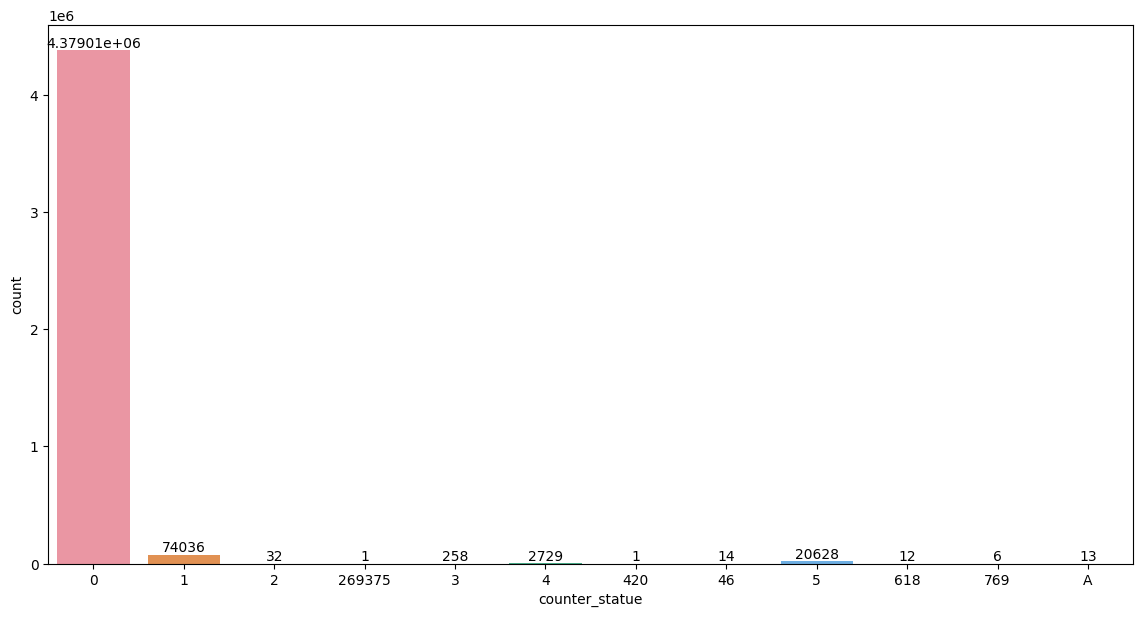

In [199]:

fig, ax = plt.subplots(figsize=(14, 7))  # ✅ correct argument name
ax = sns.countplot(x=invoice_train['counter_statue'], ax=ax)

# Add labels to each bar
for container in ax.containers:
    ax.bar_label(container)

plt.show()


In [200]:
# These column should only contain values between 0 and 5. Therefore the other values will be dropped due to the low number of entries affected
values_to_drop = ['269375', '420', '46', '618', '769', 'A']

invoice_train = invoice_train[~invoice_train['counter_statue'].isin(values_to_drop)]


In [201]:
invoice_train['counter_statue'].unique()

['0', '1', '5', '4', '3', '2']
Categories (12, object): ['0', '1', '2', '269375', ..., '5', '618', '769', 'A']

In [202]:
# why client_catg and region as category?
client_train = client_train.astype({
    #'client_catg' : 'category',
    #'region' : 'category',
    #'creation_date': 'datetime64[ns]', 
    #'target': int 
    })

In [203]:
# calculate mean values of consumption levels per client_id
def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')

In [204]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)

In [205]:
print(agg_train.shape)
agg_train.head()

(135491, 6)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286


In [206]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')

In [207]:
train.head(5)

,disrict,client_id,client_catg,region,creation_date,target,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,60,train_Client_0,11,101,1994-12-31,0,35.0,352.400000,10.571429,0.000000,0.000000
1,69,train_Client_1,11,107,2002-05-29,0,37.0,557.540541,0.000000,0.000000,0.000000
2,62,train_Client_10,11,301,1986-03-13,0,18.0,798.611111,37.888889,0.000000,0.000000
3,69,train_Client_100,11,105,1996-07-11,0,20.0,1.200000,0.000000,0.000000,0.000000
4,62,train_Client_1000,11,303,2014-10-14,0,14.0,663.714286,104.857143,117.357143,36.714286


Adding other relevant columns from the invoice_train to the 'train' dataset.

In [208]:
# Select only the columns you need from invoice_train
extra_col = ['client_id', 'tarif_type', 'counter_statue', 'counter_type']
invoice_subset = invoice_train[extra_col]

# Drop duplicates
invoice_unique = invoice_subset.drop_duplicates(subset='client_id')

# Merge ['tarif_type', 'counter_statue', 'counter_type'] to the main dataset
train = pd.merge(train, invoice_unique, on='client_id', how='left')

train.head(5)


,disrict,client_id,client_catg,region,creation_date,target,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type,counter_statue,counter_type
0,60,train_Client_0,11,101,1994-12-31,0,35.0,352.400000,10.571429,0.000000,0.000000,11,0,ELEC
1,69,train_Client_1,11,107,2002-05-29,0,37.0,557.540541,0.000000,0.000000,0.000000,11,0,ELEC
2,62,train_Client_10,11,301,1986-03-13,0,18.0,798.611111,37.888889,0.000000,0.000000,11,0,ELEC
3,69,train_Client_100,11,105,1996-07-11,0,20.0,1.200000,0.000000,0.000000,0.000000,11,0,ELEC
4,62,train_Client_1000,11,303,2014-10-14,0,14.0,663.714286,104.857143,117.357143,36.714286,11,0,ELEC


### Quick EDA for the final data frame

* It contains 2 null values that have been dropped
* There are no duplicates
* Header disrict replaced by district
* Data types are correct
* Client_id has not been modified as it will no be part of the features

In [209]:
# Check data frame shape
train.shape

(135493, 14)

In [210]:
# Check number of null values per column
train.isnull().sum()

disrict                      0
client_id                    0
client_catg                  0
region                       0
creation_date                0
target                       0
1transactions_count          2
consommation_level_1_mean    2
consommation_level_2_mean    2
consommation_level_3_mean    2
consommation_level_4_mean    2
tarif_type                   2
counter_statue               2
counter_type                 2
dtype: int64

In [211]:
# Drop null values
train = train.dropna()

In [212]:
# Count number of duplicates
print(f'The dataset contains {train.duplicated().sum()} duplicates')

The dataset contains 0 duplicates


In [213]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135491 entries, 0 to 135492
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   disrict                    135491 non-null  int64         
 1   client_id                  135491 non-null  object        
 2   client_catg                135491 non-null  int64         
 3   region                     135491 non-null  int64         
 4   creation_date              135491 non-null  datetime64[ns]
 5   target                     135491 non-null  int64         
 6   1transactions_count        135491 non-null  float64       
 7   consommation_level_1_mean  135491 non-null  float64       
 8   consommation_level_2_mean  135491 non-null  float64       
 9   consommation_level_3_mean  135491 non-null  float64       
 10  consommation_level_4_mean  135491 non-null  float64       
 11  tarif_type                 135491 non-null  category     

In [214]:
train.rename(columns={'1transactions_count': 'transactions_count',
                      'disrict' : 'district'}, 
                      inplace=True)

In [215]:
train.head(5)

,district,client_id,client_catg,region,creation_date,target,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type,counter_statue,counter_type
0,60,train_Client_0,11,101,1994-12-31,0,35.0,352.400000,10.571429,0.000000,0.000000,11,0,ELEC
1,69,train_Client_1,11,107,2002-05-29,0,37.0,557.540541,0.000000,0.000000,0.000000,11,0,ELEC
2,62,train_Client_10,11,301,1986-03-13,0,18.0,798.611111,37.888889,0.000000,0.000000,11,0,ELEC
3,69,train_Client_100,11,105,1996-07-11,0,20.0,1.200000,0.000000,0.000000,0.000000,11,0,ELEC
4,62,train_Client_1000,11,303,2014-10-14,0,14.0,663.714286,104.857143,117.357143,36.714286,11,0,ELEC


/Users/neinkob/repos/fraud-detection/.venv/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


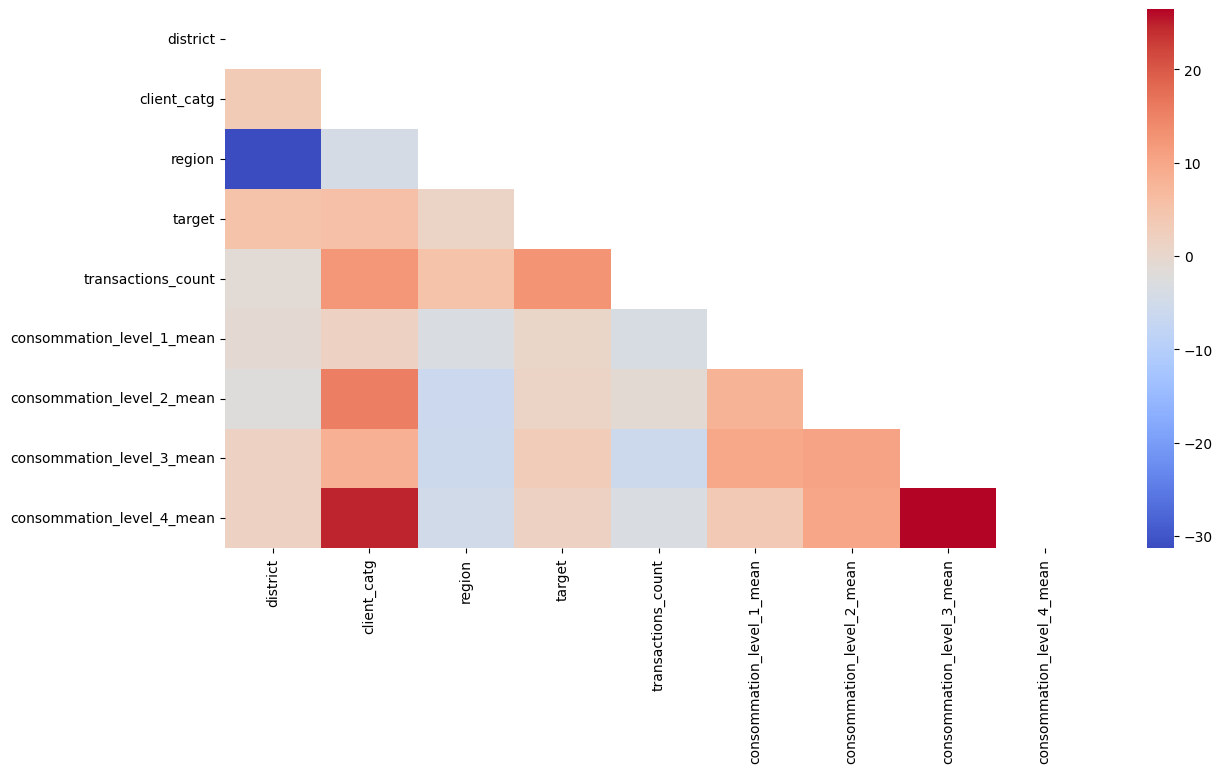

In [255]:
# Check correlation among variables
numeric_col = train.drop(columns = ['client_id', 'creation_date','counter_type', 'tarif_type', 'counter_statue'])
plt.subplots(figsize=(14, 7))
mask = np.triu(np.ones_like(numeric_col.corr(), dtype=bool))
sns.heatmap(numeric_col.corr().mul(100), mask=mask, annot=True, fmt=".2f", cmap="coolwarm");

In [217]:
train.groupby(['client_catg','target'])['target'].count()

client_catg  target
11           0         124301
             1           7191
12           0           2229
             1             92
51           0           1395
             1            283
Name: target, dtype: int64

### Baseline model

We have only three categories: 11, 12, and 51.
For our baseline model, we're gonna suppose that fraud only takes places in the category '11'

In [218]:
# Creates an extra target column, where all customers from the category 51 commit fraud
train['fraud_only_catg_51'] = train['client_catg'].apply(lambda x: 1 if x == 51 else 0)

In [219]:
train.groupby(['client_catg','fraud_only_catg_51'])['fraud_only_catg_51'].count()

client_catg  fraud_only_catg_51
11           0                     131492
12           0                       2321
51           1                       1678
Name: fraud_only_catg_51, dtype: int64

Let's check the accuracy, recall, and presicion scores

In [220]:
#
accuracy_51_is_fraudelent = accuracy_score(train['target'],train['fraud_only_catg_51'])
recall_51_is_fraudelent = recall_score(train['target'],train['fraud_only_catg_51'])
presicion_51_is_fraudelent = precision_score(train['target'],train['fraud_only_catg_51'])

print(f'Accuracy score: {round(accuracy_51_is_fraudelent,3)}')
print(f'Recall score: {round(recall_51_is_fraudelent,3)}')
print(f'Precision score: {round(presicion_51_is_fraudelent,3)}')

Accuracy score: 0.936
Recall score: 0.037
Precision score: 0.169


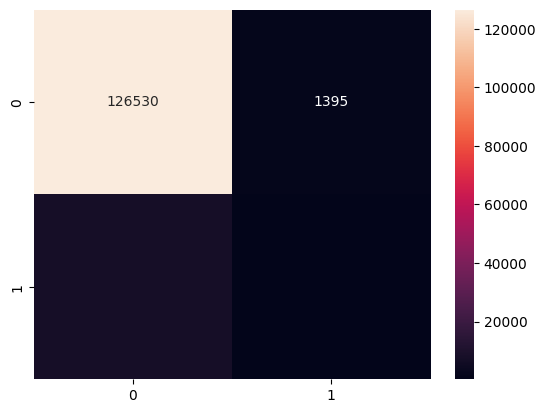

In [221]:
sns.heatmap(confusion_matrix(train['target'],train['fraud_only_catg_51']), annot = True, fmt = 'd');

This model has a very high accuracy of 0.94. However, it's very bad at detecting real frauds. 
The false negatives are especially concerning as they generate losses for the company. With a recall score of just 0.037 most of the fraud goes undetected. Therefore, we need to create a model capable of capturing most of the frauds


Now that we have the baseline model, we can get rid off of the column 'fraud_only_catg_51'

In [222]:
train = train.drop(columns='fraud_only_catg_51')

### Target distribution

The distribution is uneven, with a low percentage of fraud cases.
If we run our model like that, it will not be good enough at catching fraud. Therefore, we'll oversample to be able to have a better balance, but first let's split the data.

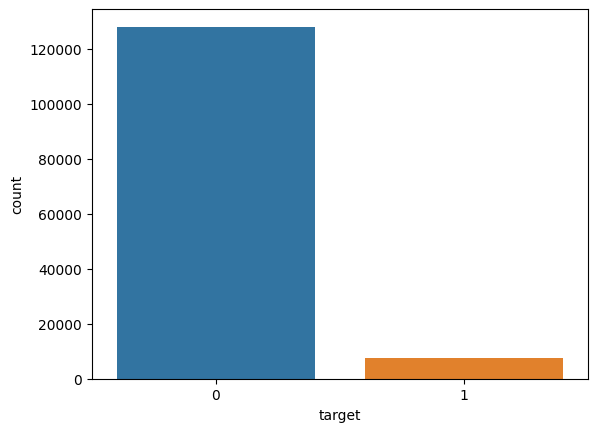

In [223]:
sns.countplot(x=train['target']);

### Running the data split

It's important to know that the train dataset will be considered as the whole dataset, which means the client_test and invoice_test will not be used at all.

In [224]:
# Split the data
X = train.drop(columns=['target','client_id','creation_date'])
y = train['target']

In [225]:
# Display the features and the target shape
print(f'X has a shape of {X.shape} and y {y.shape}')

X has a shape of (135491, 11) and y (135491,)


In [226]:
# Splits the data in training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 12, stratify=y)

In [227]:
# Displays the splits shapes
print(f'Train data: X_train has a shape of {X_train.shape} and y_shape {y_train.shape}')
print(f'Test data: X_test has a shape of {X_test.shape} and y_shape {y_test.shape}')

Train data: X_train has a shape of (94843, 11) and y_shape (94843,)
Test data: X_test has a shape of (40648, 11) and y_shape (40648,)


### Checking outliers

In [228]:
def outlier_detector(frame, drop=False):
    numeric_cols = frame.select_dtypes(include='number').columns  # only numeric columns
    outlier_indices = set()  # to store indices of all detected outliers

    for col in numeric_cols:
        Q1 = frame[col].quantile(0.25)
        Q3 = frame[col].quantile(0.75)
        IQR = Q3 - Q1

        # Detect outliers for this column
        outliers = frame[(frame[col] < Q1 - 1.5 * IQR) | (frame[col] > Q3 + 1.5 * IQR)]
        
        if not outliers.empty:
            print(f"Column '{col}': {len(outliers)} outlier(s) detected.")
            outlier_indices.update(outliers.index)

    if not outlier_indices:
        print("No outliers detected in any numeric columns.")

    if drop:
        print(f"\nDropping {len(outlier_indices)} outlier rows from dataset...")
        return frame.drop(index=list(outlier_indices))
    else:
        print(f"\nReturning {len(outlier_indices)} outlier rows (not dropped).")
        return frame.loc[list(outlier_indices)]


In [229]:
outlier_detector(X_train)

Column 'client_catg': 2776 outlier(s) detected.
Column 'transactions_count': 697 outlier(s) detected.
Column 'consommation_level_1_mean': 3811 outlier(s) detected.
Column 'consommation_level_2_mean': 12923 outlier(s) detected.
Column 'consommation_level_3_mean': 20139 outlier(s) detected.
Column 'consommation_level_4_mean': 12942 outlier(s) detected.

Returning 27620 outlier rows (not dropped).


,district,client_catg,region,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type,counter_statue,counter_type
131072,62,12,310,28.0,152.142857,0.000000,0.000000,0.000000,12,0,ELEC
131073,69,11,107,2.0,250.000000,100.000000,141.500000,0.000000,40,0,GAZ
9,60,11,101,5.0,850.800000,1629.200000,320.000000,4882.000000,11,0,ELEC
12,69,11,107,37.0,881.972973,158.567568,57.594595,0.000000,11,0,ELEC
131087,69,11,104,69.0,847.260870,236.391304,79.507246,52.942029,40,0,GAZ
...,...,...,...,...,...,...,...,...,...,...,...
131064,62,11,310,67.0,338.985075,59.537313,61.223881,4.313433,40,0,GAZ
131065,63,11,311,3.0,1230.333333,0.000000,0.000000,0.000000,11,0,ELEC
131066,63,11,306,3.0,233.333333,238.333333,0.000000,0.000000,10,0,ELEC
131068,62,11,303,76.0,676.986842,115.644737,44.276316,1.000000,40,0,GAZ


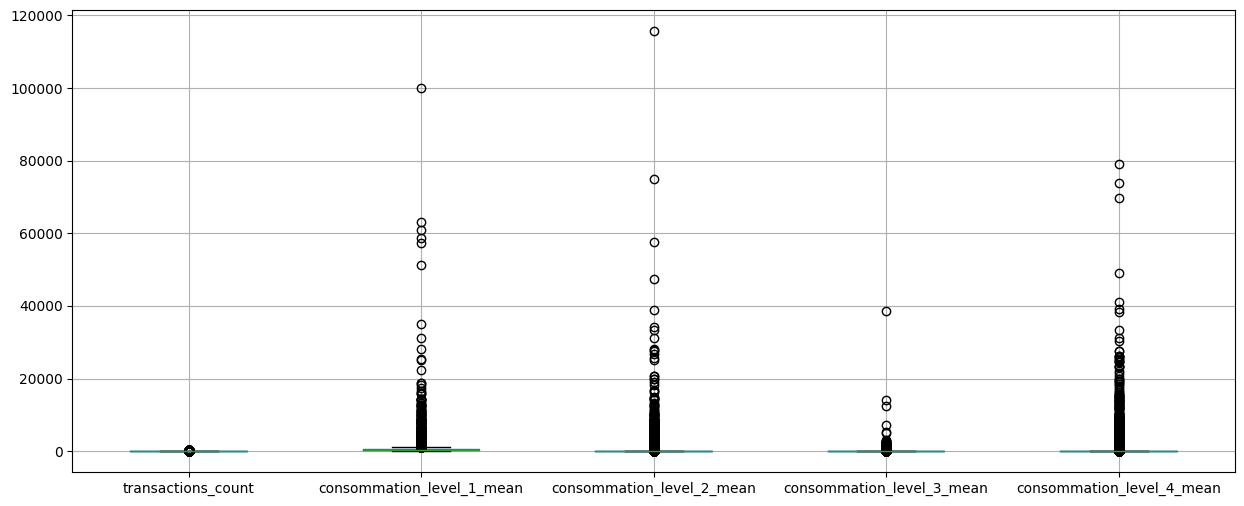

In [230]:
X_train[['transactions_count','consommation_level_1_mean','consommation_level_2_mean', 'consommation_level_3_mean', 'consommation_level_4_mean']].boxplot(figsize=(15,6))
plt.show()


The number of outliers is to high to drop them. Therefore, we'll apply a log transformation

In [231]:
cols = ['transactions_count', 'consommation_level_1_mean', 'consommation_level_2_mean',
        'consommation_level_3_mean', 'consommation_level_4_mean']
X_train.loc[:, cols] = np.log1p(X_train[cols])
X_test.loc[:, cols] = np.log1p(X_test[cols])

In [232]:
outlier_detector(X_train)

Column 'client_catg': 2776 outlier(s) detected.
Column 'consommation_level_1_mean': 7939 outlier(s) detected.
Column 'consommation_level_2_mean': 6 outlier(s) detected.
Column 'consommation_level_3_mean': 10236 outlier(s) detected.
Column 'consommation_level_4_mean': 12942 outlier(s) detected.

Returning 23669 outlier rows (not dropped).


,district,client_catg,region,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type,counter_statue,counter_type
131072,62,12,310,3.367296,5.031371,0.000000,0.000000,0.000000,12,0,ELEC
131073,69,11,107,1.098612,5.525453,4.615121,4.959342,0.000000,40,0,GAZ
3,69,11,105,3.044522,0.788457,0.000000,0.000000,0.000000,11,0,ELEC
9,60,11,101,1.791759,6.747352,7.396458,5.771441,8.493515,11,0,ELEC
12,69,11,107,3.637586,6.783295,5.072467,4.070642,0.000000,11,0,ELEC
...,...,...,...,...,...,...,...,...,...,...,...
131055,60,11,101,3.737670,5.386284,3.714761,3.021020,2.577997,10,0,ELEC
131060,69,11,104,1.791759,6.768723,5.484797,6.175867,8.754949,11,0,ELEC
131064,62,11,310,4.219508,5.828902,4.103260,4.130739,1.670238,40,0,GAZ
131068,62,11,303,4.343805,6.519128,4.759133,3.812784,0.693147,40,0,GAZ


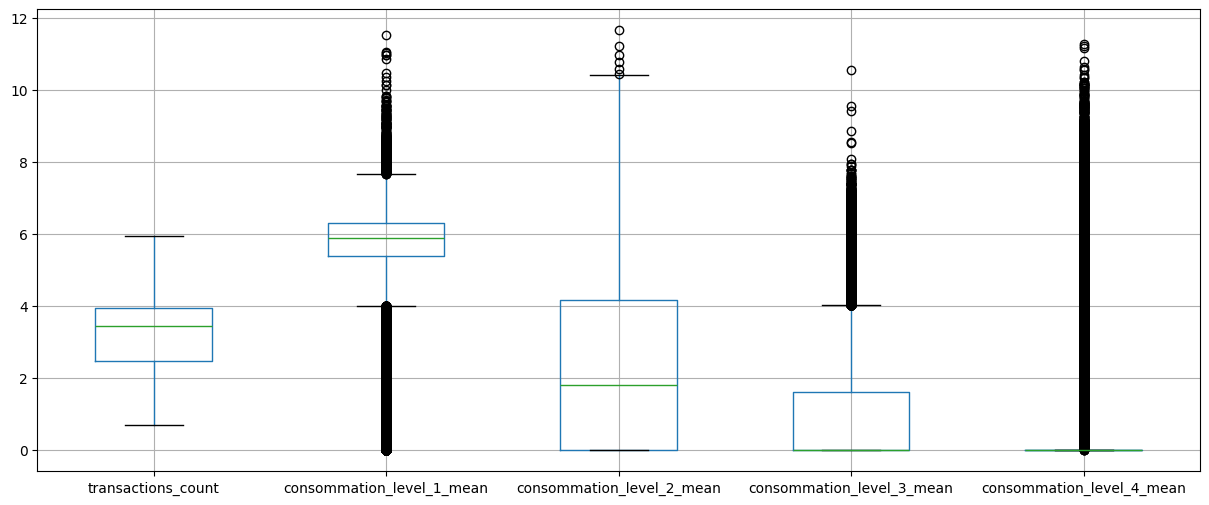

In [233]:
X_train[['transactions_count','consommation_level_1_mean','consommation_level_2_mean', 'consommation_level_3_mean', 'consommation_level_4_mean']].boxplot(figsize=(15,6))
plt.show()

### Tranforming categorical features with one-hot-encode

In [234]:
# Instantiating a OneHotEncoder object
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=True)

In [235]:
# Fit encoder to column counter_type
encoder.fit(X_train[['counter_type']])

,categories,'auto'
,drop,'first'
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [236]:
encoder.categories_

[array(['ELEC', 'GAZ'], dtype=object)]

In [237]:
encoder.get_feature_names_out()

array(['counter_type_GAZ'], dtype=object)

In [238]:
# Transform both train and test using the same encoder
X_train_encoded = encoder.transform(X_train[['counter_type']])
X_test_encoded = encoder.transform(X_test[['counter_type']])

In [239]:
X_train_encoded_dense = X_train_encoded.todense()
X_test_encoded_dense = X_test_encoded.todense()

In [240]:
X_train_encoded_df = pd.DataFrame(data=X_train_encoded_dense, columns= encoder.get_feature_names_out(['counter_type']), index=X_train.index)
X_test_encoded_df = pd.DataFrame(data=X_test_encoded_dense, columns= encoder.get_feature_names_out(['counter_type']), index=X_test.index)

In [241]:
# Drop the original column and concatenate the new encoded columns
X_train = pd.concat([X_train.drop(columns=['counter_type']), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=['counter_type']), X_test_encoded_df], axis=1)

In [242]:
X_train.head(5)

,district,client_catg,region,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type,counter_statue,counter_type_GAZ
28199,63,11,311,2.079442,5.528295,0.000000,0.000000,0.0,11,0,0.0
18397,62,11,301,4.043051,5.661409,5.614626,0.000000,0.0,40,1,1.0
47941,62,11,371,0.693147,6.579251,0.000000,0.000000,0.0,15,0,0.0
36406,69,11,104,2.772589,6.509166,4.641824,3.442553,0.0,11,0,0.0
33319,63,11,306,3.931826,6.012639,2.924236,0.000000,0.0,11,0,0.0


### Scaling

In [256]:
# defining the scaler
scaler = StandardScaler()
# List of columns that will be transformed
col_list = ['transactions_count', 'consommation_level_1_mean', 'consommation_level_2_mean', 'consommation_level_3_mean', 'consommation_level_4_mean']

In [244]:
# Scale the numeric features
X_train_scaled = scaler.fit_transform(X_train[col_list])
X_test_scaled = scaler.transform(X_test[col_list])

In [245]:
# Convert back to DataFrames with same column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=col_list, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=col_list, index=X_test.index)

In [246]:
X_train_preprocessed = np.concatenate([X_train.drop(columns=col_list),X_train_scaled_df], axis=1)
X_test_preprocessed = np.concatenate([X_test.drop(columns=col_list), X_test_scaled_df], axis=1)

In [247]:
# Check the scaling
pd.DataFrame(X_train_preprocessed)

,0,1,2,3,4,5,6,7,8,9,10
0,63,11,311,11,0,0.0,-1.0103,-0.042906,-0.957644,-0.562626,-0.35013
1,62,11,301,40,1,1.0,0.887561,0.054933,1.489075,-0.562626,-0.35013
2,62,11,371,15,0,0.0,-2.350176,0.729543,-0.957644,-0.562626,-0.35013
3,69,11,104,11,0,0.0,-0.340362,0.678031,1.065151,1.370462,-0.35013
4,63,11,306,11,0,0.0,0.78006,0.313085,0.316668,-0.562626,-0.35013
...,...,...,...,...,...,...,...,...,...,...,...
94838,62,11,304,40,1,1.0,-1.464566,0.617263,-0.957644,-0.562626,-0.35013
94839,62,11,303,40,0,1.0,1.113354,0.206529,-0.133078,-0.22732,-0.35013
94840,69,11,104,40,0,1.0,-0.896461,1.163051,-0.957644,-0.562626,-0.35013
94841,63,11,311,40,0,1.0,1.072219,-0.727477,-0.957644,-0.562626,-0.35013


### Oversampling with SMOTE

In [248]:
# Oversample the target to balance fraud and no fraud
smote = SMOTE(random_state=12)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)


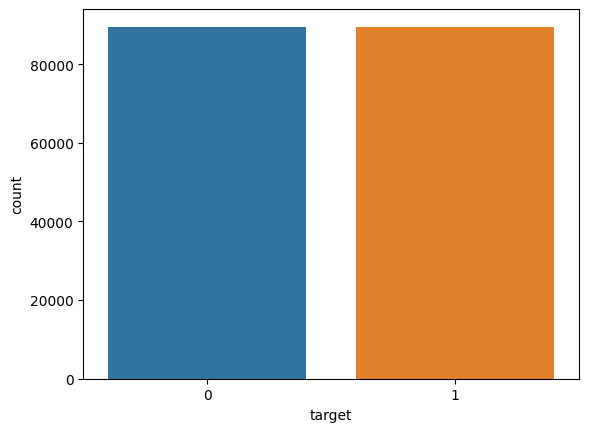

In [258]:
# Display target distribution
sns.countplot(x=y_train_res);

### Logistic Regresion

In [250]:
# Logistic regresion
lr = LogisticRegression(max_iter=1000)

In [251]:
lr.fit(X_train_res, y_train_res)

/Users/neinkob/repos/fraud-detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [252]:
# We can access the following properties to actually view the model parameter.
print(lr.coef_)
print(lr.intercept_)

[[ 7.17521651e-02 -2.45711054e-03  1.66479012e-03 -6.53105626e-02
   6.52022795e-02  1.75199852e+00  9.10281767e-01  3.46000809e-02
   1.80839514e-01  1.88820138e-01  1.34137033e-01]]
[-4.54913593]


In [259]:
y_pred = lr.predict(X_test_preprocessed)

In [254]:
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test, y_pred)}')
print(f'Precision score: {precision_score(y_test, y_pred)}')

Accuracy score: 0.6199074985239126
Recall score: 0.7088105726872247
Precision score: 0.09812172216123917


## KNN

Accuracy score: 0.7468756150364102
Recall score: 0.4431718061674009
Precision score: 0.10028910377828731


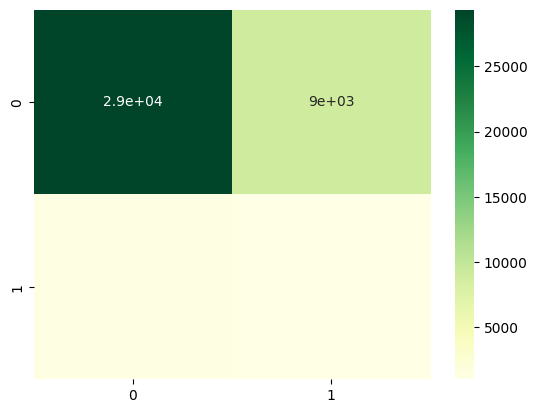

In [264]:
knn = KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=3)
knn.fit(X_train_res, y_train_res)
y_pred_knn = knn.predict(X_test_preprocessed)

print(f'Accuracy score: {accuracy_score(y_test, y_pred_knn)}')
print(f'Recall score: {recall_score(y_test, y_pred_knn)}')
print(f'Precision score: {precision_score(y_test, y_pred_knn)}')

# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, cmap='YlGn');

#### GridSearchCV

In [268]:
# Defining parameter grid (as dictionary)
param_grid = {"n_neighbors" : [2,5,10], #this actually defines the model you use
              "weights" : ["uniform", "distance"],
              "p" : [1, 2, 3]
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1)

gs.fit(X_train_res, y_train_res)

print(f'Best score: {gs.best_score_}')
print(f'Best parameters: {gs.best_params_}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[CV 2/5] END n_neighbors=2, p=1, weights=distance;, score=0.887 total time=   6.4s
[CV 1/5] END n_neighbors=2, p=1, weights=distance;, score=0.891 total time=   6.4s
[CV 3/5] END n_neighbors=2, p=1, weights=distance;, score=0.888 total time=   6.4s
[CV 5/5] END n_neighbors=2, p=1, weights=uniform;, score=0.878 total time=   6.7s
[CV 4/5] END n_neighbors=2, p=1, weights=uniform;, score=0.879 total time=   6.7s
[CV 3/5] END n_neighbors=2, p=1, weights=uniform;, score=0.875 total time=   6.8s
[CV 2/5] END n_neighbors=2, p=1, weights=uniform;, score=0.872 total time=   7.0s
[CV 1/5] END n_neighbors=2, p=1, weights=uniform;, score=0.884 total time=   7.0s
[CV 1/5] END n_neighbors=2, p=2, weights=distance;, score=0.892 total time=   5.2s
[CV 1/5] END n_neighbors=2, p=2, weights=uniform;, score=0.884 total time=   5.8s
[CV 4/5] END n_neighbors=2, p=1, weights=distance;, score=0.891 total time=   6.0s
[CV 2/5] END n_neighbors=2, p=2, weights=uniform;, score=0.873 total time=   5.7s
[CV 3/5] EN

In [269]:
print(f'Best score: {gs.best_score_}')
print(f'Best parameters: {gs.best_params_}')

Best score: 0.8890638388153244
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}


Accuracy score: 0.8230171226136588
Recall score: 0.24845814977973568
Precision score: 0.09319233311302048


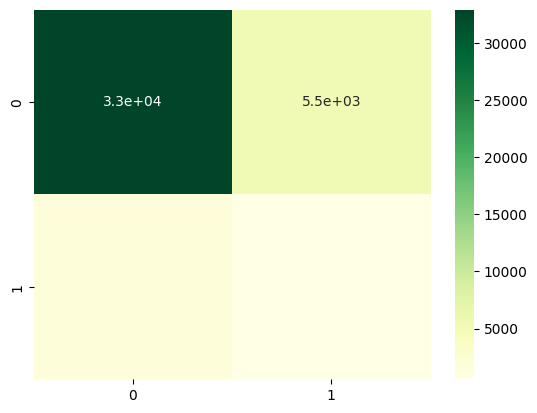

In [272]:
# Assigning the fitted KNNClassifier model with best parameter combination to a new variable knn_best
knn_best = gs.best_estimator_

# Making predictions on the test set
y_pred_knn = knn_best.predict(X_test_preprocessed)

print(f'Accuracy score: {accuracy_score(y_test, y_pred_knn)}')
print(f'Recall score: {recall_score(y_test, y_pred_knn)}')
print(f'Precision score: {precision_score(y_test, y_pred_knn)}')

# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, cmap='YlGn');